In [1]:
import rasterio as rio
from rasterio.plot import show
import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sb
from datetime import datetime, timedelta
from scipy import ndimage
from sklearn.decomposition import PCA

from ipyleaflet import Map, Marker
import folium
from sidecar import Sidecar
from PIL import Image
import cv2

from ipyleaflet import Map, ImageOverlay, basemaps, basemap_to_tiles, WidgetControl
import os
from base64 import b64encode
from ipywidgets import IntSlider, SelectionSlider, VBox, Layout, Checkbox, Box, Label

In [2]:
data = rio.open('../R/2016-10-3_1000min.tif')
data_bounds = (data.bounds.left, data.bounds.right, \
          data.bounds.bottom, data.bounds.top)
bounds_arr = [[data.bounds.bottom, data.bounds.left], \
                  [data.bounds.top, data.bounds.right]]
bounds_arr

[[44.90833862304688, -1.9407999999999994], [57.94833862304688, 10.4992]]

In [ ]:
# transform pixel coordinates to lat long --> create heatmap to visualize with folium
rio.transform.xy(data.transform, 0, 0)

In [ ]:
def raster_to_heatmaps(raster_ts):
    ...

In [3]:
def raster_to_pngs(raster_data, t_start, t_delta=timedelta(minutes=15), colormap=cm.rainbow, min_var = 0):
    
    img_arr = raster_data.read()
    
    print(np.nanmin(img_arr), np.nanmax(img_arr))
    
    img_arr[img_arr>2000] = 2000 #np.nan
    
    img_arr[img_arr==0] = np.nan
    img_arr = np.log(img_arr)
    
    print(np.nanmin(img_arr), np.nanmax(img_arr))
    img_arr = (img_arr - np.nanmin(img_arr)) / (np.nanmax(img_arr) - np.nanmin(img_arr))
    #print(img_arr)
    
    img_arr[:, np.nanvar(img_arr, axis=0)<min_var] = np.nan
    
    x, y,z = np.where(np.isnan(img_arr))
    img_arr = colormap(img_arr, bytes = True)
    img_arr[x,y,z, -1] = 0
    
    print(img_arr.shape)
    
    #alpha = np.zeros(img_arr.shape)
    #alpha[np.where(np.isfinite(img_arr))] = 255
    #print(alpha.shape)
    
    #img_arr = np.uint8(colormap(img_arr)*255)
    
    #img_arr = np.concatenate((img_arr, alpha))
    
    if min_var > 0:
        dirname = 'png_filtered_var'
    else:
        dirname = 'png'
    os.makedirs(f'./{dirname}', exist_ok=True)
    
    t_range = np.array([t_start + t_delta*i for i in range(img_arr.shape[0])], dtype=datetime)
    
    for i in range(img_arr.shape[0]):
        im = Image.fromarray(img_arr[i])
        im.save(f'{dirname}/{t_range[i]}.png','PNG')
        
    
    #t_range = np.arange(t_start, datetime(2015,7,1), timedelta(days=1)).astype(datetime)
    return t_range

In [4]:
t_start = datetime(2016, 10, 3, 17)
t_range = raster_to_pngs(data, t_start)
t_range = raster_to_pngs(data, t_start, min_var=0.0025)

0.0 inf


<ipython-input-3-979e134a813f>:7: RuntimeWarning: invalid value encountered in greater
  img_arr[img_arr>2000] = 2000 #np.nan


-5.2198973 7.6009026


<ipython-input-3-979e134a813f>:16: RuntimeWarning: Degrees of freedom <= 0 for slice.
  img_arr[:, np.nanvar(img_arr, axis=0)<min_var] = np.nan
<ipython-input-3-979e134a813f>:16: RuntimeWarning: invalid value encountered in less
  img_arr[:, np.nanvar(img_arr, axis=0)<min_var] = np.nan


(67, 1304, 1244, 4)
0.0 inf
-5.2198973 7.6009026
(67, 1304, 1244, 4)


<ipython-input-3-d6501d6ad39b>:2: RuntimeWarning: invalid value encountered in greater
  img_arr[np.greater(img_arr, 2000)] = 2000
<ipython-input-3-d6501d6ad39b>:7: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = np.nanvar(img_arr, axis=0)
<ipython-input-3-d6501d6ad39b>:9: RuntimeWarning: Degrees of freedom <= 0 for slice.
  ax[0].imshow(np.nanvar(img_arr, axis=0)<0.0025, cmap='rainbow')
<ipython-input-3-d6501d6ad39b>:9: RuntimeWarning: invalid value encountered in less
  ax[0].imshow(np.nanvar(img_arr, axis=0)<0.0025, cmap='rainbow')


(0.0, 0.06434332)

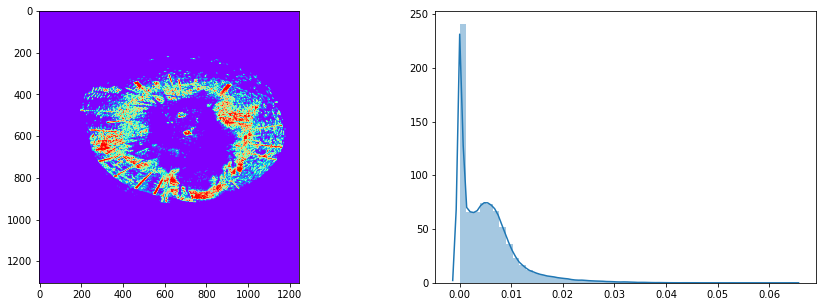

In [3]:
img_arr = data.read()
img_arr[np.greater(img_arr, 2000)] = 2000
img_arr[img_arr==0] = np.nan
img_arr = np.log(img_arr)
img_arr = (img_arr - np.nanmin(img_arr)) / (np.nanmax(img_arr) - np.nanmin(img_arr))

var = np.nanvar(img_arr, axis=0)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(np.nanvar(img_arr, axis=0)<0.0025, cmap='rainbow')
sb.distplot(var, ax=ax[1])
np.nanmin(var), np.nanmax(var)

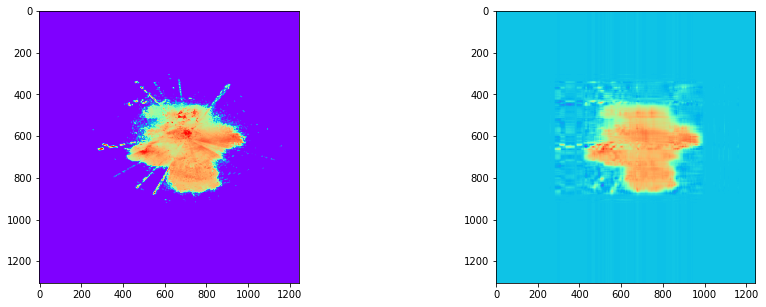

In [21]:
img_data = np.nan_to_num(img_arr, np.nanmin(img_arr))
X = img_data[40]
mu = np.mean(X, axis=0)

pca = PCA(50)
pca.fit(X)

nComp = 10
Xhat = np.dot(pca.transform(X)[:,:nComp], pca.components_[:nComp,:])
Xhat += mu

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(X, cmap='rainbow')
ax[1].imshow(Xhat, cmap='rainbow')


<ipython-input-10-962cec06b175>:3: RuntimeWarning: invalid value encountered in greater
  img[img>2000] = 2000


1304 1244


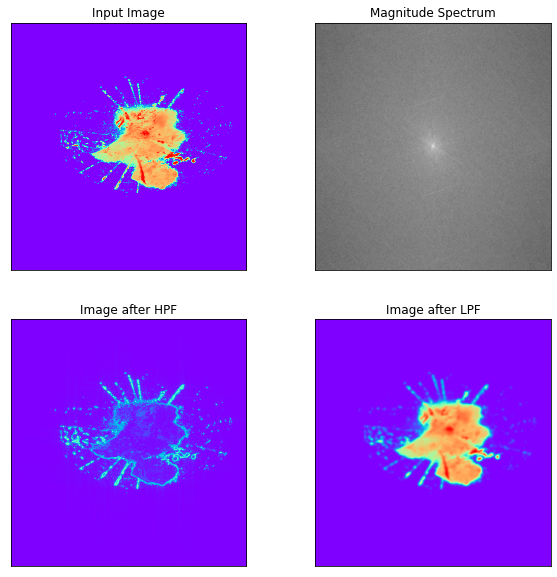

In [10]:
img = data.read()[5]

img[img>2000] = 2000
    
img[img==0] = np.nan
img = np.log(img)
img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img))
img = np.nan_to_num(img)

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

rows, cols = img.shape
print(rows, cols)
crow,ccol = int(rows/2) , int(cols/2)

width = 50

fshift_hpf = fshift.copy()
fshift_lpf = fshift.copy()
fshift_hpf[crow-width:crow+width, ccol-width:ccol+width] = 0
fshift_lpf[:crow-width, :crow-width] = 0
fshift_lpf[crow+width:, crow+width:] = 0
f_ishift_hpf = np.fft.ifftshift(fshift_hpf)
img_hpf = np.fft.ifft2(f_ishift_hpf)
img_hpf = np.abs(img_hpf)
f_ishift_lpf = np.fft.ifftshift(fshift_lpf)
img_lpf = np.fft.ifft2(f_ishift_lpf)
img_lpf = np.abs(img_lpf)

x = cv2.getGaussianKernel(5,10)
gaussian = x*x.T
fft_gaussian = np.fft.fft2(x)
fft_shift_gaussian = np.fft.fftshift(fft_gaussian)
fft_ishift_gausssian = np.fft.ifftshift(fft_shift_gaussian)
img_gaussian = np.fft.ifft2(fft_ishift_gausssian)
img_gaussian = np.abs(img_gaussian)
img_gaussian = ndimage.gaussian_filter(img, 5)

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(img, cmap = 'rainbow')
ax[0,0].set(title='Input Image', xticks=[], yticks=[])
ax[0,1].imshow(magnitude_spectrum, cmap = 'gray')
ax[0,1].set(title='Magnitude Spectrum', xticks=[], yticks=[])
ax[1,0].imshow(img_hpf, cmap = 'rainbow')
ax[1,0].set(title='Image after HPF', xticks=[], yticks=[])
ax[1,1].imshow(img_gaussian, cmap = 'rainbow')
ax[1,1].set(title='Image after LPF', xticks=[], yticks=[])

plt.show()

In [6]:
data.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 1244,
 'height': 1304,
 'count': 9,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.01, 0.0, -1.9407999999999994,
        0.0, -0.01, 57.94833862304688)}

In [30]:
1000/15

66.66666666666667

In [33]:
bounds=((data.bounds.bottom, data.bounds.left), \
                 (data.bounds.top, data.bounds.right))

center = ((bounds[0][0]+bounds[1][0])/2,(bounds[0][1]+bounds[1][1])/2)
m = Map(center=center, zoom=6)

slider = SelectionSlider(description='time step:', 
                    options=t_range, 
                    orientation='horizontal',
                    layout={'width': '500px'}
)
var_filter = Checkbox(description='Filter out low variance', layout={'width': '10'})
#ilter_box = Box([Label(value='Filter out low variance'), var_filter])

widget_control1 = WidgetControl(widget=slider, position='topright')
m.add_control(widget_control1)
widget_control2 = WidgetControl(widget=var_filter, position='topright')
m.add_control(widget_control2)

io = None

def display_png(t):
    global io
    
    if var_filter.value:
        dirname = 'png_filtered_var'
    else:
        dirname = 'png'
    filename=f'{dirname}/{t}.png'
    with open(filename, 'rb') as f:
        d = b64encode(f.read())
    d = d.decode('ascii')
    p = f'data:image/{dirname};base64,' + d

    if io is None:
        io = ImageOverlay(url=p, bounds=bounds, opacity=0.7)
        m.add_layer(io)
    else:
        #m.remove_layer(io)
        #io = ImageOverlay(url=p, bounds=bounds, opacity=0.6)
        #m.add_layer(io)
        io.url = p
        
def show_snapshot(change):
    display_png(change.new)
    
def reload(change):
    display_png(slider.value)
        

slider.observe(show_snapshot, 'value')
var_filter.observe(reload, 'value')
display_png(t_range[0])

sc = Sidecar(title='bird vis')
with sc:
    display(m)

Map(center=[51.42833862304688, 4.2792], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

In [153]:
center = [51.164878, 5.295410]

img = data.read()
#img = np.random.rand(*img.shape)
img[img==0] = np.nan    
img = np.log(img)
img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img))

@widgets.interact(
    t=(0, data.read().shape[0]-1))
def plot(t=0):

    fig, ax = plt.subplots(figsize=(15,15))
    #ax = plt.axes(projection=ccrs.Mercator(central_longitude=center[0], min_latitude=data.bounds.bottom, max_latitude=data.bounds.top), extent=bounds)
    #ax.coastlines()
    
    m = ax.imshow(img[t], extent=data_bounds, interpolation='none')
    #ax.set(xlabel='longitude', ylabel='latitude')
    plt.colorbar(m)
    
    plt.show()

interactive(children=(IntSlider(value=0, description='t', max=8), Output()), _dom_classes=('widget-interact',)…

In [70]:
center = [51.164878, 5.295410]
m = folium.Map(location=center, tiles = 'Stamen Terrain', zoom_start = 6)

img = data.read()
img[img==0] = np.nan
#img = np.nan_to_num(img)
img = np.log(img)
img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img))

sc = Sidecar(title='Sidecar Output')
time = 0
with sc:
    #@widgets.interact(time=(0, data.read().shape[0]-1))
    #def raster_overlay(time):
        #img = np.log(img)
        #img = np.random.rand(*img.shape)
        
    folium.raster_layers.ImageOverlay(plt.cm.get_cmap('rainbow')(img[time]), opacity=0.6, bounds=bounds_arr, mercator_project=True).add_to(m)
    display(m)

In [3]:
sc = Sidecar()
with sc:
    print('test')

test
